# Notebook 04: Reporte Final - Política de Inventario 2024
## Objetivo: Combinar el pronóstico base (GBR) con el cálculo de riesgo (GPD por producto) para generar la política de inventario final.

## Metodología:

- Cargar el pronóstico base de 2024 (data/processed/predicciones_demanda_2024.csv).

- Cargar el mapeo de stock de seguridad por producto (data/processed/stock_seguridad_por_producto.csv).

- Unir (merge) las dos tablas.

- Calcular la columna final: stock_total_recomendado = prediccion_ventas + stock_de_seguridad.

- Guardar el reporte final.

## 0. Configuración e Importación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

## 1. Cargar Artefactos del Modelo
Cargamos las dos salidas de nuestros pipelines anteriores.

In [2]:
# 1. Cargar el pronóstico base (12,000 filas = 1000 prod * 12 meses)
path_pronostico = '../data/processed/predicciones_demanda_2024.csv'
df_pronostico = pd.read_csv(path_pronostico)

print(f"Pronóstico base cargado: {len(df_pronostico)} filas.")
print(df_pronostico.head())

# 2. Cargar el stock de seguridad (1,000 filas = 1000 prod * 1 valor)
path_riesgo = '../data/processed/stock_seguridad_por_producto.csv'
df_riesgo = pd.read_csv(path_riesgo)

print(f"\nStock de seguridad cargado: {len(df_riesgo)} filas.")
print(df_riesgo.head())

Pronóstico base cargado: 12000 filas.
        fecha  prod_id  prediccion_ventas
0  2024-01-01        0        2059.984012
1  2024-02-01        0        1472.463920
2  2024-03-01        0        1106.306216
3  2024-04-01        0         880.477605
4  2024-05-01        0         827.766047

Stock de seguridad cargado: 635 filas.
   prod_id  stock_de_seguridad
0        0              1089.0
1        1               970.0
2        3              1220.0
3        4              1108.0
4        6               119.0


## 2. Unir Pronóstico y Riesgo

Usamos un merge para asignar a cada una de las 12,000 filas de pronóstico el stock de seguridad que le corresponde a su prod_id.

In [3]:
# Unir (merge) los dos dataframes usando 'prod_id' como llave
df_final = pd.merge(
    df_pronostico,
    df_riesgo,
    on='prod_id',
    how='left'
)

# Llenar con 0 si algún producto no tuvo cálculo de riesgo (ej. productos nuevos)
df_final['stock_de_seguridad'] = df_final['stock_de_seguridad'].fillna(0)

print("DataFrames unidos:")
print(df_final.head())

DataFrames unidos:
        fecha  prod_id  prediccion_ventas  stock_de_seguridad
0  2024-01-01        0        2059.984012              1089.0
1  2024-02-01        0        1472.463920              1089.0
2  2024-03-01        0        1106.306216              1089.0
3  2024-04-01        0         880.477605              1089.0
4  2024-05-01        0         827.766047              1089.0


## 3. Calcular Política de Inventario Final

Aquí aplicamos la fórmula de negocio:

Stock Total a Planificar = prediccion_ventas + stock_de_seguridad

In [4]:
# Aplicar la fórmula final
df_final['stock_total_recomendado'] = df_final['prediccion_ventas'] + df_final['stock_de_seguridad']

# Opcional: Redondear la predicción base
df_final['prediccion_ventas'] = df_final['prediccion_ventas'].round(0)

# Reordenar columnas para claridad
columnas_finales = [
    'fecha', 
    'prod_id', 
    'prediccion_ventas',      # Pronóstico base (media)
    'stock_de_seguridad',     # Riesgo (calculado por GPD)
    'stock_total_recomendado' # Decisión final
]

df_final = df_final[columnas_finales]

print("Política de inventario final generada:")
print(df_final.head())

Política de inventario final generada:
        fecha  prod_id  prediccion_ventas  stock_de_seguridad  \
0  2024-01-01        0             2060.0              1089.0   
1  2024-02-01        0             1472.0              1089.0   
2  2024-03-01        0             1106.0              1089.0   
3  2024-04-01        0              880.0              1089.0   
4  2024-05-01        0              828.0              1089.0   

   stock_total_recomendado  
0              3148.984012  
1              2561.463920  
2              2195.306216  
3              1969.477605  
4              1916.766047  


## 4. Visualización de la Política de Inventario
Ahora que tenemos el pronóstico y el riesgo unidos, podemos graficar la política de inventario completa para un producto de ejemplo.

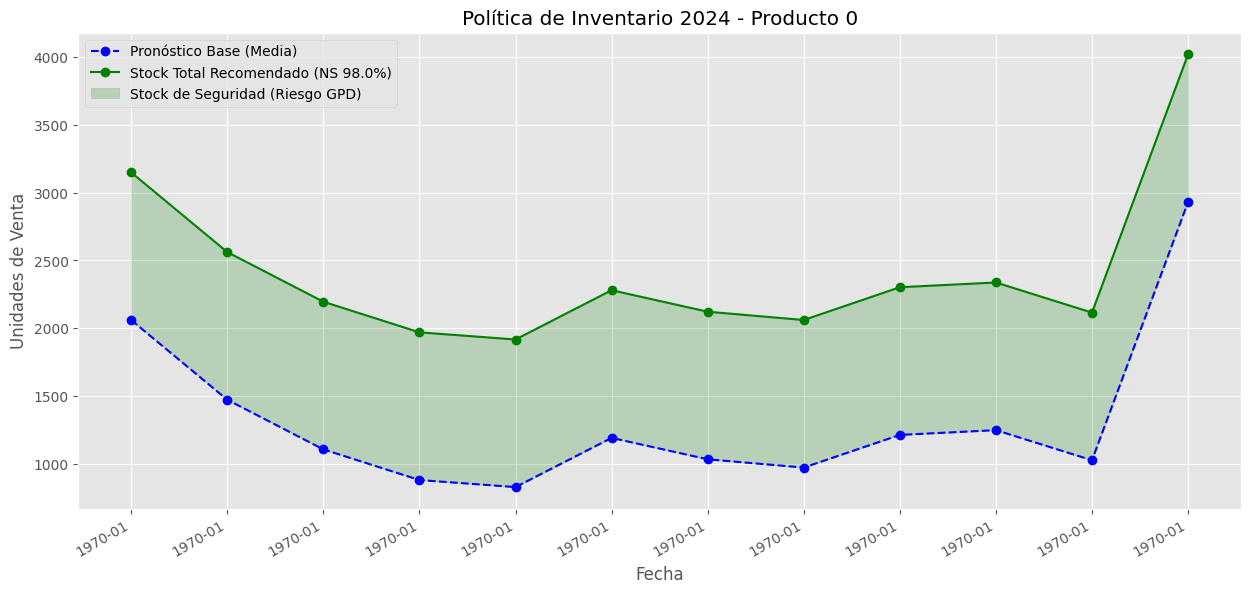

In [6]:
import matplotlib.pyplot as plt

# --- Elige un producto para graficar ---
PRODUCT_ID_TO_PLOT = 0 # Puedes cambiar este número (ej. 0, 1, 42, etc.)

# --- Define el Nivel de Servicio (debe ser el mismo que usaste en el notebook 02) ---
NIVEL_SERVICIO_OBJETIVO = 0.98
# ---------------------------------------------------------------------------------

# Filtrar el DataFrame final para ese producto
df_plot = df_final[df_final['prod_id'] == PRODUCT_ID_TO_PLOT]

if df_plot.empty:
    print(f"Producto {PRODUCT_ID_TO_PLOT} no encontrado.")
else:
    plt.figure(figsize=(15, 7))
    
    # 1. El pronóstico base (la media)
    plt.plot(
        df_plot['fecha'], 
        df_plot['prediccion_ventas'], 
        label='Pronóstico Base (Media)', 
        color='blue', 
        marker='o', 
        linestyle='--'
    )
    
    # 2. El stock total recomendado (Pronóstico + Stock de Seguridad)
    plt.plot(
        df_plot['fecha'], 
        df_plot['stock_total_recomendado'], 
        label=f'Stock Total Recomendado (NS {NIVEL_SERVICIO_OBJETIVO*100}%)', # <-- Ahora sí funciona
        color='green', 
        marker='o'
    )
    
    # 3. El área sombreada que representa el Stock de Seguridad
    plt.fill_between(
        df_plot['fecha'], 
        df_plot['prediccion_ventas'], 
        df_plot['stock_total_recomendado'], 
        color='green', 
        alpha=0.2, 
        label='Stock de Seguridad (Riesgo GPD)'
    )
    
    plt.title(f'Política de Inventario 2024 - Producto {PRODUCT_ID_TO_PLOT}')
    plt.ylabel('Unidades de Venta')
    plt.xlabel('Fecha')
    plt.legend()
    plt.grid(True)
    
    # Formatear el eje X para mostrar bien las fechas
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate() # Rotar fechas
    
    plt.show()

## 4. Guardar Reporte Final

Este es el archivo CSV que se entrega al negocio.

In [ ]:
# Guardar el reporte final
path_salida_final = '../data/processed/politica_inventario_final_2024.csv'

df_final.to_csv(path_salida_final, index=False)

print(f"Reporte final guardado en: {path_salida_final}")

# Ver un ejemplo de un producto
print("\n--- Ejemplo para Producto 0 ---")
print(df_final[df_final['prod_id'] == 0])

Reporte final guardado en: ../data/processed/politica_inventario_final_2024.csv

--- Ejemplo para Producto 0 ---
         fecha  prod_id  prediccion_ventas  stock_de_seguridad  \
0   2024-01-01        0             2060.0              1089.0   
1   2024-02-01        0             1472.0              1089.0   
2   2024-03-01        0             1106.0              1089.0   
3   2024-04-01        0              880.0              1089.0   
4   2024-05-01        0              828.0              1089.0   
5   2024-06-01        0             1191.0              1089.0   
6   2024-07-01        0             1033.0              1089.0   
7   2024-08-01        0              972.0              1089.0   
8   2024-09-01        0             1213.0              1089.0   
9   2024-10-01        0             1248.0              1089.0   
10  2024-11-01        0             1026.0              1089.0   
11  2024-12-01        0             2931.0              1089.0   

    stock_total_recomendado 